[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edwinRNDR/workshop-meme-viz/blob/master/notebooks/CLIP-feature-extractor.ipynb)


# CLIP prompt feature extractor

## Install dependencies


In [1]:
!pip3 install transformers==4.23.1 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2
#!pip3 install tsnecuda==3.0.1+cu112 -f https://tsnecuda.isx.ai/tsnecuda_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 41.5 MB/s 
     |████████████████████████████████| 163 kB 74.1 MB/s 


## Download dataset

In [2]:
%%capture
!gdown 1lGoNJBM3cNEe935eO9MvFkQLIYnAppjj
!unzip scraped-memes.zip

## Configure prompts

In [3]:
prompts = ["a photograph of a man",
           "a photograph of a woman", 
           "a photograph of a group of people",
           "a photograph of a young man",
           "a photograph of an old man",
           "a photograph of a young woman",
           "a photograph of an old man2",
           "a dark background",
           "a bright background",
           "a photograph of a happy person",
           "a photograph of an angry person",
           "a photograph of a sad person",
           "a photograph of a drawing",
           "a photograph of an ugly person",
           "a photograph of a pretty person"
          ]

## Extract features

Use CLIP to extract features from images



In [6]:
import os
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
from torch.cuda.amp import autocast
from tqdm import tqdm

device = "cuda"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model = model.to(device)
#processor = processor.to(device)

image_dir = "scraped-memes"
source_dirs = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]


prompt_logits_path = "prompt-logits.csv"

with autocast():
  with open(prompt_logits_path, "w") as f:
    print(",".join(prompts),file=f)
    for source_dir in tqdm(sorted(source_dirs)):
        image_path = os.path.join(image_dir, source_dir, "meme-image.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True).to(device)

            outputs = model(**inputs)

            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            logits = [str(logits_per_image[0][index].item()) for index, label in enumerate(prompts)]
            print(",".join(logits),file=f)
            

 50%|█████     | 3143/6245 [02:17<02:09, 23.99it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6245/6245 [05:06<00:00, 20.38it/s]


## Reduce features to two dimensions using TSNE

In [7]:
from sklearn.manifold import TSNE
import pandas as pd

prompt_logits_path = "prompt-logits.csv"


features = pd.read_csv(prompt_logits_path)
print(features.shape)

tsne = TSNE(n_components=2, perplexity=25, learning_rate=10)
embed = tsne.fit_transform(features)
embed = embed.reshape(features.shape[0],2)
pd.DataFrame(embed).to_csv("prompt-tsne.csv")



(6245, 15)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


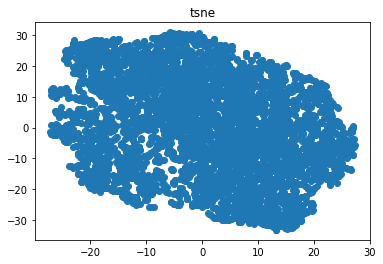

In [9]:
import matplotlib.pyplot as plt

plt.scatter(embed[:,0], embed[:,1])
plt.title("tsne")
plt.show()

